In [2]:
import torch
from alfi.datasets import SingleCellKidney, Pancreas

import numpy as np

In [3]:
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
single_gene = False
cpe_index = 1710

if single_gene:
    dataset = Pancreas(data_dir='../../data', gene_index=cpe_index)
    cpe_index = 0
else:
    dataset = Pancreas(data_dir='../../data')
# cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]

In [4]:
num_cells = dataset[0].shape[1]
num_genes = 1 if single_gene else 2000
num_outputs = 2 * num_genes
num_latents = 1 if single_gene else 10
num_inducing = 10  # (I x m x 1)
num_timepoint_choices = 50
end_t = 20
use_natural = True

In [5]:
data = dataset.m_observed.squeeze()
y_target = data
u_y = y_target[:num_genes]  # (num_genes, num_cells)
s_y = y_target[num_genes:]  # (num_genes, num_cells)
# w = torch.logical_and(u_y > 0, s_y > 0)
# u_y = torch.gather(u_y, dim=1, index=w)
print(s_y.shape)

x = s_y > torch.tensor(np.percentile(s_y, 98, axis=1)).unsqueeze(-1)
s = s_y * x
x = u_y > torch.tensor(np.percentile(u_y, 98, axis=1)).unsqueeze(-1)
u = u_y * x
s = s.unsqueeze(-1)
u = u.unsqueeze(1)
gamma = torch.matmul(u, s).squeeze(1).squeeze(1)
l2 = s.squeeze(2).square().sum(dim=1)
gamma /= l2
gamma = gamma.unsqueeze(-1)
if single_gene:
    gamma += 0.1
    print(gamma)

torch.Size([2000, 3696])


In [6]:
data = dataset.m_observed
cells = data.permute(1, 2, 0)  # (O, C, 1)
u_y = cells[:num_genes]  # (num_genes, num_cells)
s_y = cells[num_genes:]  # (num_genes, num_cells)
nonzero_mask = list()
for gene_index in range(num_genes):
    nonzero_mask.append(torch.logical_and(s_y[gene_index, :, 0] > 0,
                                          u_y[gene_index, :, 0] > 0))
nonzero_mask = torch.stack(nonzero_mask).repeat(2, 1)


In [7]:
print(l2[cpe_index])
print(gamma.shape)
print(gamma.min())
print(gamma.max())
# s_low = s_y[s_sort_ind[-50:]]
# print(s_low)
# u_y.shape, s_y.shape

tensor(19980.4258)
torch.Size([2000, 1])
tensor(0.)
tensor(37.4716)


In [8]:
import scvelo as scv
scv.tl.velocity(dataset.loom)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


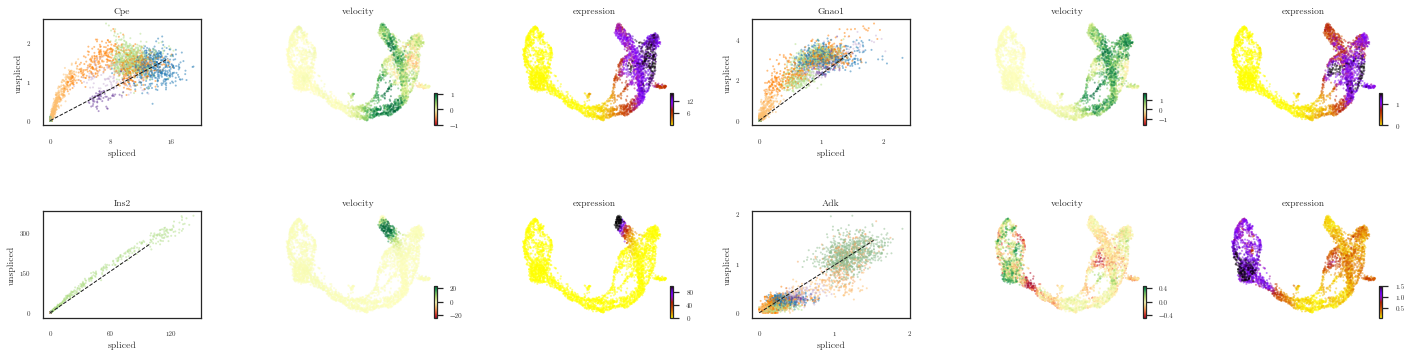

In [9]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [11]:
    # data,
    # var_names="velocity_genes",
    # n_top_genes=None,
    # max_iter=10,
    # assignment_mode="projection",
    # t_max=None,
    # fit_time=True,
    # fit_scaling=True,
    # fit_steady_states=True,
    # fit_connected_states=None,
    # fit_basal_transcription=None,
    # use_raw=False,
    # load_pars=None,
    # return_model=None,
    # plot_results=False,
    # steady_state_prior=None,
    # add_key="fit",
    # copy=False,
    # n_jobs=None,
    # backend="loky",
    # **kwargs,
from scvelo.tools import DynamicsRecovery
from scvelo.utils import get_connectivities
use_raw = False
fit_connected_states = True
fit_basal_transcription = None
load_pars = None
conn = get_connectivities(dataset.loom)

dataset.loom.uns["recover_dynamics"] = {
    "fit_connected_states": fit_connected_states,
    "fit_basal_transcription": fit_basal_transcription,
    "use_raw": use_raw,
}
dyn = DynamicsRecovery(
    dataset.loom,
    'Cpe',
    use_raw=use_raw,
    load_pars=load_pars,
    max_iter=10,
    fit_time=True,
    fit_steady_states=True,
    fit_connected_states=conn,
    fit_scaling=1.,#True,
    fit_basal_transcription=fit_basal_transcription,
    steady_state_prior=None)

dyn.fit(assignment_mode="projection")

KeyboardInterrupt: 

In [88]:
print(dyn.scaling)
print(dyn.alpha, dyn.beta, dyn.gamma)
print(dyn.t_.max(), dyn.t.max(), dyn.t.min())

0.45
1.471111032888293 0.45 0.09364852326621921
29.93555051320559 40.046005 0.0


In [89]:
scv.tl.recover_dynamics(dataset.loom, fit_scaling=1, n_jobs=10)
scv.tl.latent_time(dataset.loom)

recovering dynamics (using 10/12 cores)
    finished (0:01:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


  0%|          | 0/1038 [00:00<?, ?gene/s]

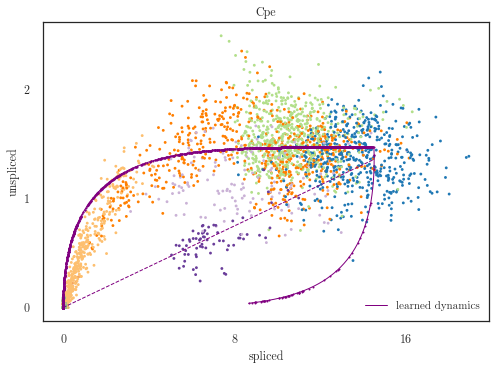

(100,)


In [97]:
#'Gnao1', 'Ins2', 'Adk'
scv.pl.scatter(dataset.loom, basis= ['Cpe'], ncols=4, frameon=True)

velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)

In [95]:
print(dataset.loom.var['fit_alpha'][cpe_index])
print(dataset.loom.var['fit_beta'][cpe_index])
print(dataset.loom.var['fit_gamma'][cpe_index])
print(dataset.loom.layers['fit_t'][:,cpe_index].max())

2.961211504818006
2.0129082296420124
0.1885058831763941
18.87065412751722


In [ ]:
adata = dataset.loom
_layers = adata[:, cpe_index].layers
u = _layers['Mu']
s = _layers['Ms']


In [17]:
print(dataset.loom.layers)

Layers with keys: spliced, unspliced, Ms, Mu, velocity, variance_velocity, fit_t, fit_tau, fit_tau_
